# 1. Preparing Data

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew

## Contract data

In [2]:
df = pd.read_csv('../data/raw/voc_person_contracts.csv.gz')
print('loaded contract data')
print(f'Total number of contracts: {df.shape[0]:,}')
df.head()

loaded contract data
Total number of contracts: 774,200


,vocop_id,full_name,first_name,patronymic,family_name_prefix,family_name,place_of_origin,place_id,disambiguated_person,person_cluster_id,...,changed_ship_at_cape_voyage_id,return_voyage_id,remark,source_id,scan_permalink,full_name_normalized,first_name_normalized,patronymic_normalized,family_name_prefix_normalized,family_name_normalized
0,104944,Adriaen van Renteregem,Adriaen,NaN,van,Renteregem,Wassenaar,141865.0,1.0,415682.0,...,NaN,96993,NaN,3339,NL-HaNA_1.04.02_12674_0192.jpg,Adriaan van Renteregem,Adriaan,NaN,van,Renteregem
1,104945,Adriaen van der Meulen,Adriaen,NaN,van der,Meulen,Cooltiensplate,25576.0,1.0,406243.0,...,NaN,96942,NaN,3339,NL-HaNA_1.04.02_12674_0194.jpg,Adriaan van der Meul,Adriaan,NaN,van der,Meul
2,104946,Arnoldus Coutrel,Arnoldus,NaN,NaN,Coutrel,Antwerpen,6486.0,1.0,1.0,...,NaN,97025,NaN,3339,NL-HaNA_1.04.02_12674_0196.jpg,Arnoldus Koetrel,Arnoldus,NaN,NaN,Koetrel
3,104947,Albert Coolman,Albert,NaN,NaN,Coolman,Amsterdam,5532.0,1.0,77235.0,...,NaN,-1,NaN,3339,NL-HaNA_1.04.02_12674_0198.jpg,Albert Koolman,Albert,NaN,NaN,Koolman
4,104948,Anthonij Bonel,Anthonij,NaN,NaN,Bonel,Amsterdam,5532.0,1.0,65732.0,...,NaN,-1,NaN,3339,NL-HaNA_1.04.02_12674_0200.jpg,Antoni Bonel,Antoni,NaN,NaN,Bonel


### Variables

- __vocop_id__: the unique id for each contract <br>
- __disambiguated_person__: indicates whether the person is disambiguated (0 = no, 1 = yes). <br>
- __person_cluster_id__: id that refers to unique person. If a person is disambiguated, multiple contracts can belong to one person <br>
- __date_begin_contract__: start date of contract <br>
- __outward_voyage_id__: unique id of outward voyage.

In [7]:
# select relevant columns

df = df[['vocop_id', 'disambiguated_person', 'person_cluster_id', 'date_begin_contract', 'outward_voyage_id']]

In [126]:
# Remove contracts without a start data
nans = df['date_begin_contract'].isnull().sum()
print(f'Number of contacts with missing data in start date field: {nans}')
df = df.dropna(subset=['date_begin_contract'])


# Only select disambiguated records
records = df.loc[df['disambiguated_person'] == 1, 'person_cluster_id'].astype(int).values
print(f'Number of disambiguated records: {len(records):,}')

# Construct year variable
# Pandas does not like old dates, so rather than using Datetime, we extract it from the string
df['year'] = df['date_begin_contract'].str.split('-', expand=True)[0].astype(int)
df = df.sort_values(by='year')
assert df["year"].min() == 1633 and df["year"].max() == 1794

df.to_csv('../data/voyages_clean.csv', index=False)

Number of contacts with missing data in start date field: 0
Number of disambiguated records: 546,973


In [9]:
sailors_df = df[df['outward_voyage_id'] != 0]

In [41]:
contract_counts = sailors_df.groupby('outward_voyage_id')['vocop_id'].count()

# Dutch-Asiatic Shipping (DAS)

In [85]:
das = pd.read_excel('../data/raw/das.xlsx')

das = das[das['voyRGPDeel'] == 166] #only outbound voyages
das = das[(das['voydepartureY'] >= 1633) & (das['voydepartureY'] <= 1794)] #same time period as contracts

outward_voyage_ids = das['voyId'].values

print(f'number of outward voyages: {len(outward_voyage_ids)}')


number of outward voyages: 4352


In [86]:
das_onboard = pd.read_excel('../data/raw/das.xlsx', sheet_name='onboard')
das_onboard = das_onboard[das_onboard['onbVoyageId'].isin(outward_voyage_ids)] # select outbound vogages in time period

`onbI`: The number on board at departure. 
`onbII`: The number dying between the Netherlands and the Cape. 
`onbIII`: The number who left the ship at the Cape.  
`onbIV`: The number who came on board at the Cape.
`onbV`: The number dying on the whole voyage. 
`onbVI`: The number on board on arrival in Asia.

For our purposes, we only need `onbI` and `onbIV`
These columns contain dirty data, so we need to extract only the integers.


In [87]:
das_onboard['onbI'] = das_onboard['onbI'].astype(str).str.extract('(\d+)') #extract digits (400 / 500, +- 400)
das_onboard['onbIV'] = das_onboard['onbIV'].astype(str).str.extract('(\d+)')
das_onboard.dropna(subset=['onbI'], inplace=True) # drop nans
das_onboard['onbIV'] = das_onboard['onbIV'].fillna(0)


In [88]:
das_onboard['counts'] = das_onboard['onbI'].astype(int) + das_onboard['onbIV'].astype(int)

In [89]:
das_onboard = das_onboard[['onbVoyageId', 'counts']]

# remove extreme values
das_onboard = das_onboard[das_onboard['onbVoyageId'] != 93096]
das_onboard = das_onboard[das_onboard['onbVoyageId'] != 92445]

In [91]:
das_onboard_counts = das_onboard.groupby('onbVoyageId')['counts'].sum().reset_index()

In [92]:
das_onboard_counts

,onbVoyageId,counts
0,91478,189
1,91479,148
2,91480,348
3,91481,56
4,91482,159
...,...,...
3935,95822,181
3936,95823,237
3937,95826,151
3938,95827,192


In [59]:
compare_counts = pd.merge(das_onboard_counts, contract_counts, left_on='onbVoyageId', right_on='outward_voyage_id')

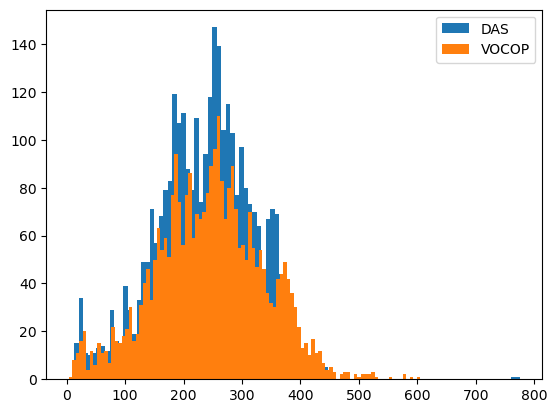

In [62]:
plt.hist(compare_counts['counts'].values, label='DAS', bins=100)
plt.hist(compare_counts['vocop_id'].values, label='VOCOP', bins=100)
plt.legend()

In [117]:
## Impute missing values

impute_missing = pd.DataFrame(outward_voyage_ids, columns=['outward_voyage_id'])


In [118]:
impute_missing = pd.merge(impute_missing, das_onboard_counts, left_on ='outward_voyage_id', right_on='onbVoyageId', how='left')

In [123]:
skew(impute_missing['counts'])



-0.1660142401527538

The distribution is slightly skewed, so we might as well take the median

In [113]:
# impute_missing['counts'].fillna(value=impute_missing['counts'].mean(), inplace=True)
# impute_missing['counts'].sum()

969920.5197969542

In [124]:
impute_missing['counts'].fillna(value=impute_missing['counts'].median(), inplace=True)
impute_missing['counts'].sum()

972859.0

In [133]:
impute_missing = pd.merge(impute_missing, das[['voyId', 'voydepartureY']], left_on='outward_voyage_id', right_on=['voyId'])

In [136]:
impute_missing[['outward_voyage_id', 'counts', 'voydepartureY']].to_csv('../data/seafarer_counts.csv', index=False)

In [137]:
impute_missing

,outward_voyage_id,onbVoyageId,counts,voyId,voydepartureY
0,91651,NaN,230.0,91651,1640.0
1,91881,NaN,230.0,91881,1653.0
2,91473,NaN,230.0,91473,1633.0
3,91474,NaN,230.0,91474,1633.0
4,91475,NaN,230.0,91475,1633.0
...,...,...,...,...,...
4347,95823,95823.0,237.0,95823,1794.0
4348,95824,NaN,230.0,95824,1794.0
4349,95825,NaN,230.0,95825,1794.0
4350,95826,95826.0,151.0,95826,1794.0
